# Importing Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'xXTopEm8LWcP95sWfbAG'

# Question 2: Find Data Set and Import 

In [3]:
# Importing the Bureau of Labor Statistics Data "Employment: Total nonfarm industry for US" variable.

data = quandl.get('BLSE/CES0000000001')

In [4]:
data.head(5)

,Value
Date,
1939-01-31,29923.0
1939-02-28,30100.0
1939-03-31,30280.0
1939-04-30,30094.0
1939-05-31,30299.0


In [5]:
data.shape

(986, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

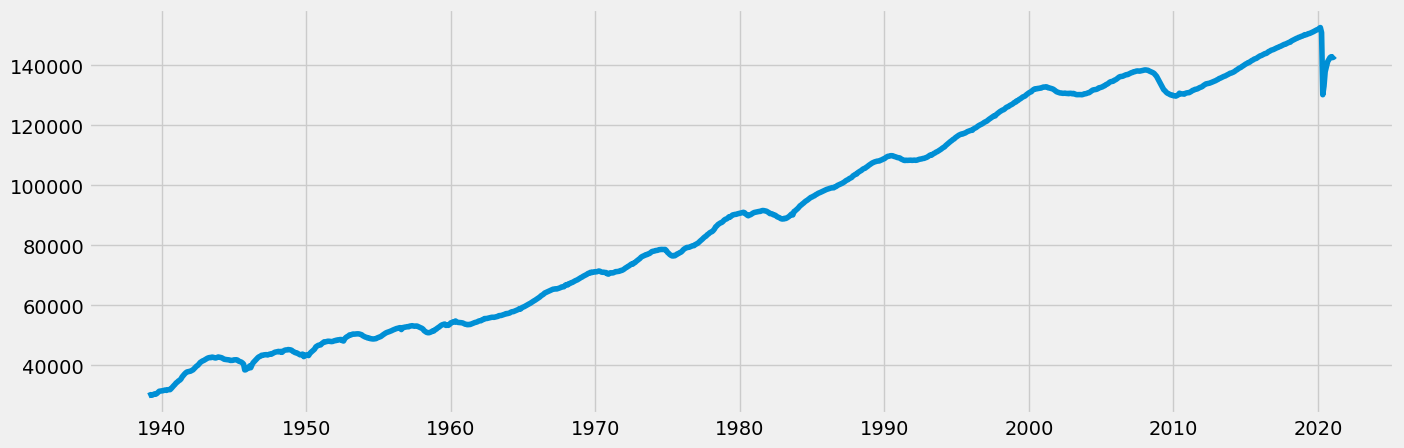

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

# Question 3: Create a subset 

In [9]:
# Reset index to use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1939-01-31,29923.0
1,1939-02-28,30100.0
2,1939-03-31,30280.0
3,1939-04-30,30094.0
4,1939-05-31,30299.0


In [11]:
data_sub = data_2.loc[(data_2['Date'] >= '1990-01-01') & (data_2['Date'] < '2021-02-28')]

In [12]:
data_sub.shape

(373, 2)

In [13]:
data_sub.head()

,Date,Value
612,1990-01-31,109199.0
613,1990-02-28,109435.0
614,1990-03-31,109644.0
615,1990-04-30,109686.0
616,1990-05-31,109839.0


In [14]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Value
datetime,
1990-01-31,109199.0
1990-02-28,109435.0
1990-03-31,109644.0
1990-04-30,109686.0
1990-05-31,109839.0


# I wanted to narrow down the dates in use since I wanted to better show the changes that happened in 2020, but also provide enough historical precedent in terms of employment #'s.  That is why I decided to start at 1990 so that the general trend of the past 30 years can be shown, but I can also clearly see what happened in 2020.

# Question 4: Line chart

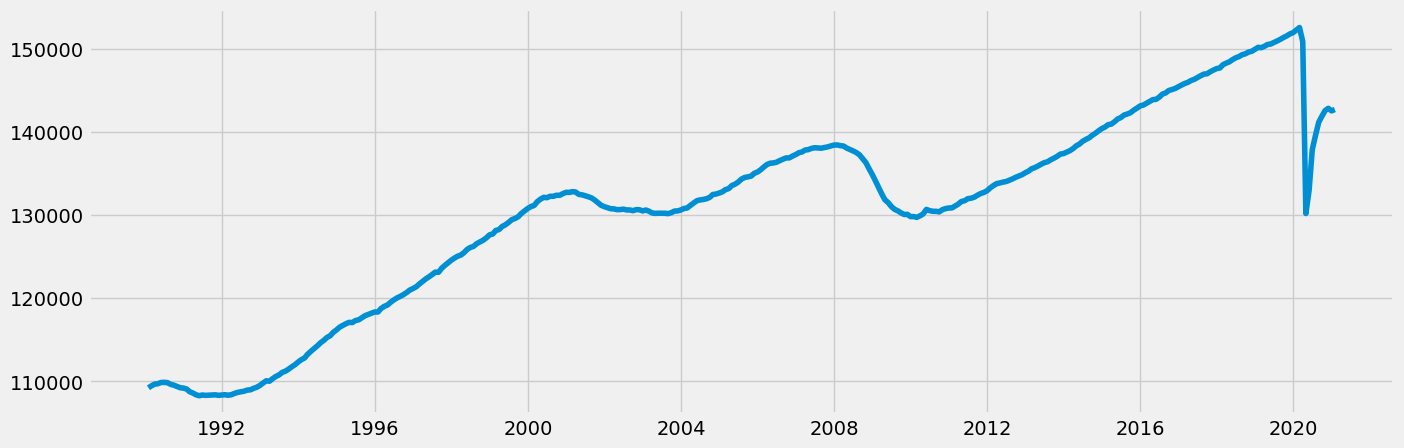

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# Check for missing values 

data_sub.isnull().sum()

Value    0
dtype: int64

In [17]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

3

# Question 5: Decompose data's components

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

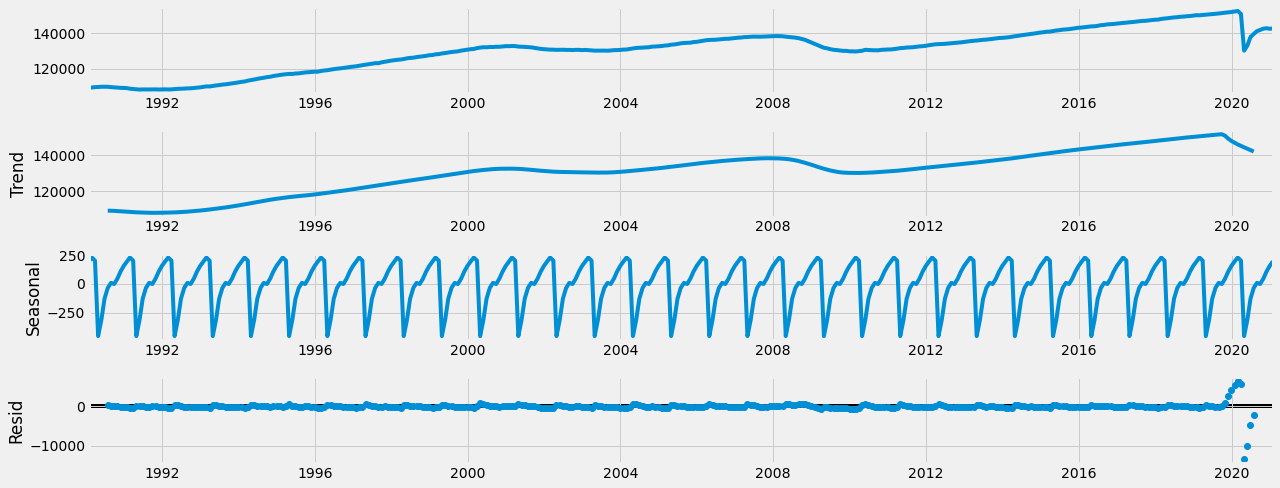

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

# The level and the trend seem to be very similar which implies that there is not much noise (other than around 2020).  The trend overall seems to rise in a linear fashion with the exception of around 2009 (global financial crisis) and 2020 (Covid-19).  This makes it a dominant trned.  There is definitely seasonality as seen by the yearly rising and falling.  The only noise seems to be for 2020 where there was a big drop and a big rise due to job losses and gains during shutdowns and re-openings.  With a trend and seasonality, I would say this is a non-stationary series.

# Question 6: Dickey-Fuller test

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.506116
p-value                          0.530484
Number of Lags Used              2.000000
Number of Observations Used    370.000000
Critical Value (1%)             -3.448148
Critical Value (5%)             -2.869383
Critical Value (10%)            -2.570948
dtype: float64


# The null hypothesis is the presence of a unit root (I want to disprove that there is a unit root which would mean the data is stationary). Since the test statistic (-1.506116) is larger than the critical values (-2.869383 for the 5%) that would mean that I cannot reject the null hypothesis.  That would mean my data is non-stationary.  I would also want a p-value below 0.05 for the test result to be significant.  It is at 0.530484.  

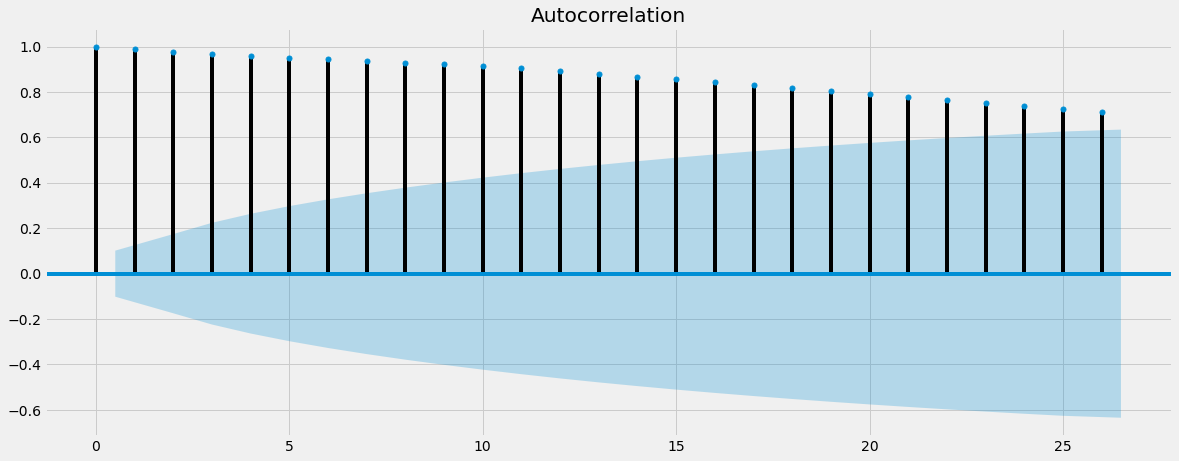

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# Question 7: Stationarizing the Bureau of Labor Statistics Data

In [23]:
data_diff = data_sub - data_sub.shift(1) 

In [24]:
data_diff.dropna(inplace = True) # Removing the missing values that came about as a result of the differencing. 

In [25]:
data_diff.head()

,Value
datetime,
1990-02-28,236.0
1990-03-31,209.0
1990-04-30,42.0
1990-05-31,153.0
1990-06-30,17.0


In [26]:
data_diff.columns

Index(['Value'], dtype='object')

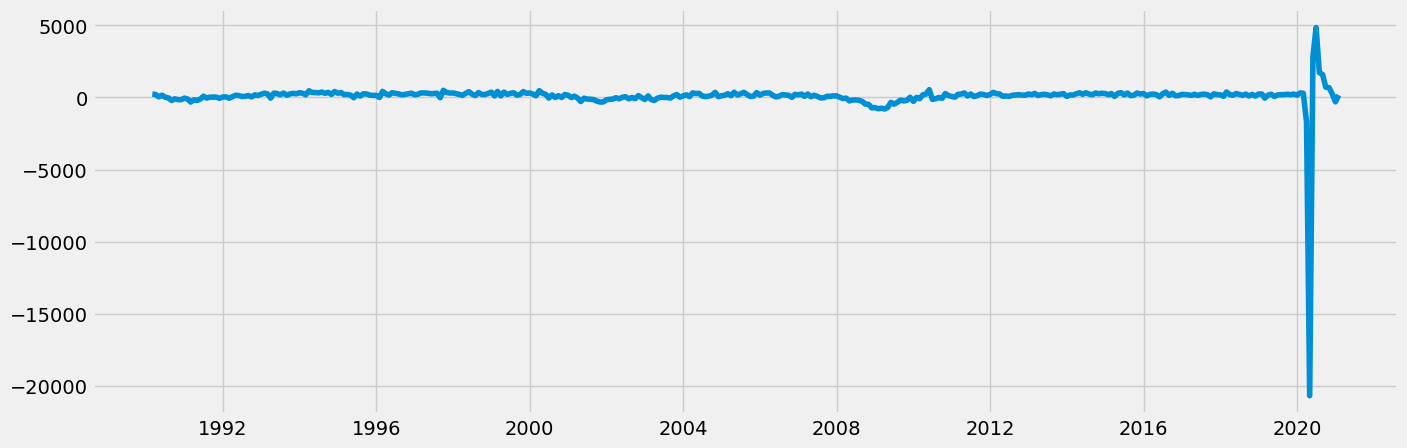

In [27]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [28]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.586572e+01
p-value                        9.102768e-29
Number of Lags Used            1.000000e+00
Number of Observations Used    3.700000e+02
Critical Value (1%)           -3.448148e+00
Critical Value (5%)           -2.869383e+00
Critical Value (10%)          -2.570948e+00
dtype: float64


# The p-value is now below 0.05 and the test statistic is now higher than the critical value (of all three 1%, 5%, and 10%).  In terms of the Autocorrelation, I do not need a second round of differencing since there are less than ten significant lags (I only see one).  

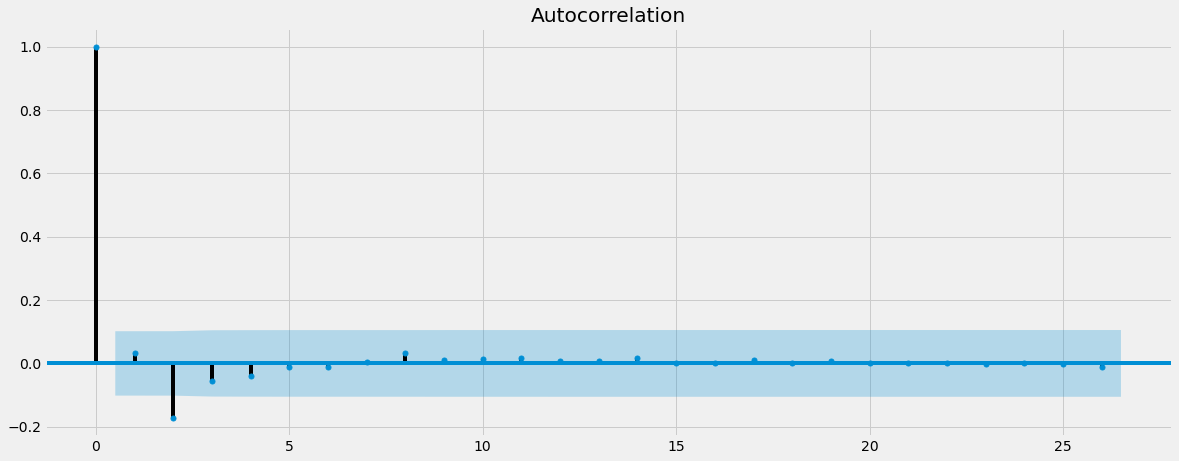

In [29]:
plot_acf(data_diff)
plt.show()